In [64]:
%load_ext autoreload
%autoreload 2
import sys
from tqdm.notebook import tqdm
import scqubits as sq
sys.path.append('..')
filedirectory = "\\Users\\diego\\Documents\\resilio_FERBO\\FB_W10_S4\\run3\\"
from src.utilities import *
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from src.jja import jja_resonances, jja_eigensys, C_matrix, L_inv_matrix
%matplotlib inline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single tone

In [2]:
#number = 100055  # run1, bad phase
#number = 476  # run 3
number = 1826   # run 3
sts = load_data(filedirectory +  "FBW10S4_" +str(number))
sts['freq'] = sts['freq']*1e-9

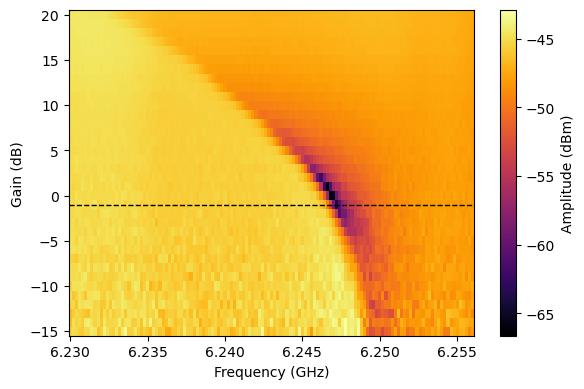

In [6]:

fig, ax = plt.subplots(figsize=(6,4))  # Create a new figure and axis if not provided
x_key = 'freq'
y_key = 'gain'
z_key = 'amp'
data_dict = sts
x_data = data_dict[x_key]
y_data = data_dict[y_key]
z_data = data_dict[z_key]
phase_data = data_dict['phase']

if x_data.ndim == 1:
    Y = y_data
    X = np.tile(x_data, (Y.shape[1], 1)).T
elif y_data.ndim == 1: # In case it's inverted the axis.
    X = x_data
    Y = np.tile(y_data, (X.shape[1], 1)).T

# mesh = ax.pcolormesh(X[:,:160], Y[:,:160], z_data[:,:160], shading='auto', cmap = 'inferno') #, vmin=vmin, vmax=vmax) for the run 1
mesh = ax.pcolormesh(X[5:,:], Y[5:,:], z_data[5:,:], shading='auto', cmap = 'inferno') #, vmin=vmin, vmax=vmax,**kwargs)

plt.axhline(-1,color = 'k', linestyle = '--',linewidth = 1)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Gain (dB)')
# ax.set_xticks([6.205, 6.210, 6.215, 6.220])
cbar = fig.colorbar(mesh, ax=ax, label='Amplitude (dBm)')

fig.tight_layout()
# plt.savefig('jja1tone.png',dpi = 800)
plt.show()

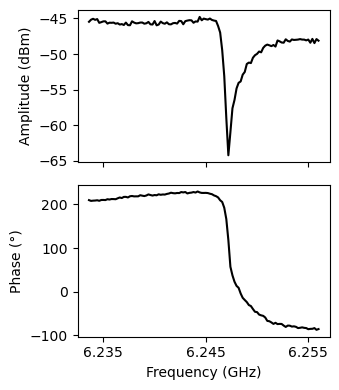

In [7]:
yvalue = -1
idx = (np.abs(y_data - yvalue)).argmin()

fig, ax = plt.subplots(2,1,sharex = True, figsize=(3.5,4))
ax[0].plot(x_data[0,18:], z_data[idx, 18:],'k')
ax[0].set_ylabel('Amplitude (dBm)')

ax[1].plot(x_data[0,18:], phase_data[idx, 18:] + 360,'k')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Phase (°)')
ax[1].set_xticks([6.235, 6.245, 6.255])
plt.tight_layout()
# plt.savefig('jja1tonee.png',dpi = 800)

# Two tone

In [26]:

datasets = {
    'tts_gain':     1453,
    'tts_gain2':    1587,
    'tts_gain3':    1666,
}

In [27]:
data = {}
for key, datanumber in tqdm(datasets.items()):
    data[key] = load_data(filedirectory + "FBW10S4_" +str(datanumber))
    if 'freq' in data[key]:
        data[key]['freq'] *= 1e-9

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
resonances = np.array([6.249, 9, 12.1482, 13.4229, 13.8177, 15.142])
index_modes = np.arange(1,len(resonances)+1)
index_modes_interpolate = np.linspace(index_modes.min(), index_modes.max(),1000)

In [16]:
def minimizer(params):
    resonances_fit =jja_resonances(params)[1:len(resonances)+1]*1e-9
    return np.sum((resonances - resonances_fit)**2)

bounds = [(3.2,4), (10,100), (50,158),(0.5,4), (0.1,5)]
# Ljj (nH),  Cjj (fF),  Cg = (aF),  Cg_big (fF),  Cin = (fF),  N = 170,   Cout = 0

result = differential_evolution(func=minimizer,bounds=bounds)

 c:\Users\diego\Documents\FERBO_git\Fermionic-bosonic-qubit\notebooks\..\src\jja.py: 55

In [48]:
result.x

array([ 3.21354538, 29.50337706, 57.96059637,  2.17034151,  0.1       ])

 c:\Users\diego\Documents\FERBO_git\Fermionic-bosonic-qubit\notebooks\..\src\jja.py: 55

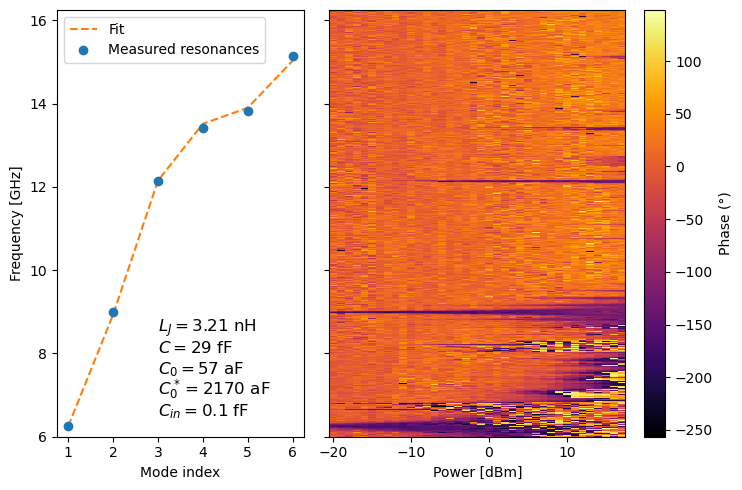

In [57]:
latex_style(False)
plt.close('all')
fig,ax=plt.subplots(1,2,figsize=(7.5,5),sharey=True,gridspec_kw={'width_ratios': [1, 1.5]})
index_modes2 = np.append(index_modes,7)

ax[0].plot(index_modes, jja_resonances(result.x)[1:len(resonances)+1]*1e-9, linestyle='dashed', color='C1', label='Fit')
ax[0].plot(index_modes, resonances, 'o', color='C0', label='Measured resonances')
# ax[0].plot(index_modes_interpolate, resonance_model(index_modes_interpolate, *fit), '-',label='Analytical expression')
ax[0].text(3.0, 8.5, rf'$L_J = {np.round(result.x[0],2)}$ nH', fontsize=12, ha='left')
ax[0].text(3.0, 8.0, rf'$C = {int(result.x[1])}$ fF', fontsize=12, ha='left')
ax[0].text(3.0, 7.5, rf'$C_0 = {int(result.x[2])}$ aF', fontsize=12, ha='left')
ax[0].text(3.0, 7.0, rf'$C_0^* = {int(result.x[3]*1e3)}$ aF', fontsize=12, ha='left')
ax[0].text(3.0, 6.5, rf'$C_{{in}} = {int(result.x[4]*1000)/1000}$ fF', fontsize=12, ha='left')
ax[0].set_xlabel('Mode index')
ax[0].set_ylabel('Frequency [GHz]')

_,_,mesh = plot3D(
    data_dict=data['tts_gain'],
    x_key='gain',
    y_key='freq',
    z_key='phase',
    flatten_vertical=1,
    ax=ax[1],
    fig=fig,
    add_colorbar = False,
    cmap = 'inferno'
    )
ax[0].legend(loc = 'upper left', fontsize = 10)
ax[0].set_xticks([1,2,3,4,5,6])

# ax[1].set_ylabel('Frequency [GHz]')
ax[1].set_xlabel('Power [dBm]')
cbar = fig.colorbar(mesh, ax = ax[1])
cbar.set_label('Phase (°)')

fig.tight_layout()
# plt.savefig('jja2tone.png',dpi = 800)
plt.show()

In [65]:
from scipy.sparse import diags
from scipy.linalg import eigh

def jja_resonances_Cin(params):
    Ljj = result.x[0]*1e-9
    Cjj = result.x[1]*1e-15
    Cg = result.x[2]*1e-18
    Cg_big = result.x[3]*1e-15
    Cin = params[0]*1e-15
    
    N = 170
    Cout = 0

    eigenvalues_C, eigenvectors_C = eigh(C_matrix(N,Cjj,Cg,Cg_big,Cin,Cout))
    Lambda_inv_sqrt = np.diag(1 / np.sqrt(eigenvalues_C))
    C_inv_sqrt = np.dot(eigenvectors_C, np.dot(Lambda_inv_sqrt, eigenvectors_C.T)) # spectral decomposition of C^-1/2
    matrix_operation = np.dot(C_inv_sqrt, np.dot(L_inv_matrix(N,Ljj), C_inv_sqrt)) # C^-1/2 L^-1 C^-1/2
    eigvals = eigh(matrix_operation, eigvals_only=True) # eigenvalues and eigvecs of C^-1/2 L^-1 C^-1/2

    return np.sqrt(eigvals)/2/np.pi



In [66]:
def minimizer(params):
    resonances_fit =jja_resonances_Cin(params)[1:len(resonances)+1]*1e-9
    return np.sum((resonances - resonances_fit)**2)

bounds = [(0.01,5)]
# Ljj (nH),  Cjj (fF),  Cg = (aF),  Cg_big (fF),  Cin = (fF),  N = 170,   Cout = 0

result = differential_evolution(func=minimizer,bounds=bounds)

 C:\Users\diego\AppData\Local\Temp\ipykernel_2504\2828651170.py: 20